 # <center>SN2025fvw</center>

 <center> Zisen Dai dzs23@mails.tsinghua.edu.cn </center>


This document presents the code and report for processing the observational light curve data of SN2025fvw.

数据文件读取成功！
数据形状: (65, 9)
列名: ['catname', 'MJD', 'mag', 'magerr', 'cali', 'calierr', 'filter', 'stdstars', 'magnitude']
波段: ['B' 'V' 'g' 'r' 'i']
星等范围: 13.74 - 16.64
误差范围: 0.003 - 0.021
开始绘制各波段数据...
波段 B: 13 个数据点
  - 星等范围: 14.120 - 16.640
  - 误差范围: 0.006 - 0.021
  - 平均误差: 0.012
  最佳拟合模型: Gaussian-like Model, 残差: 243.096
波段 V: 13 个数据点
  - 星等范围: 13.801 - 15.960
  - 误差范围: 0.005 - 0.014
  - 平均误差: 0.008
  最佳拟合模型: Gaussian-like Model, 残差: 442.172
波段 g: 13 个数据点
  - 星等范围: 13.740 - 16.121
  - 误差范围: 0.004 - 0.012
  - 平均误差: 0.007
  最佳拟合模型: Gaussian-like Model, 残差: 412.986
波段 i: 13 个数据点
  - 星等范围: 14.189 - 16.628
  - 误差范围: 0.005 - 0.018
  - 平均误差: 0.010
  最佳拟合模型: Improved SN Model, 残差: 273.091
波段 r: 13 个数据点
  - 星等范围: 13.740 - 15.973
  - 误差范围: 0.003 - 0.009
  - 平均误差: 0.006
  最佳拟合模型: Gaussian-like Model, 残差: 502.554
绘制残差图...
  B 波段: Gaussian-like Model, RMS残差: 0.048
  V 波段: Gaussian-like Model, RMS残差: 0.046
  g 波段: Gaussian-like Model, RMS残差: 0.048
  i 波段: Improved SN Model, RMS残差: 0.039
  r 波段: Gaussia

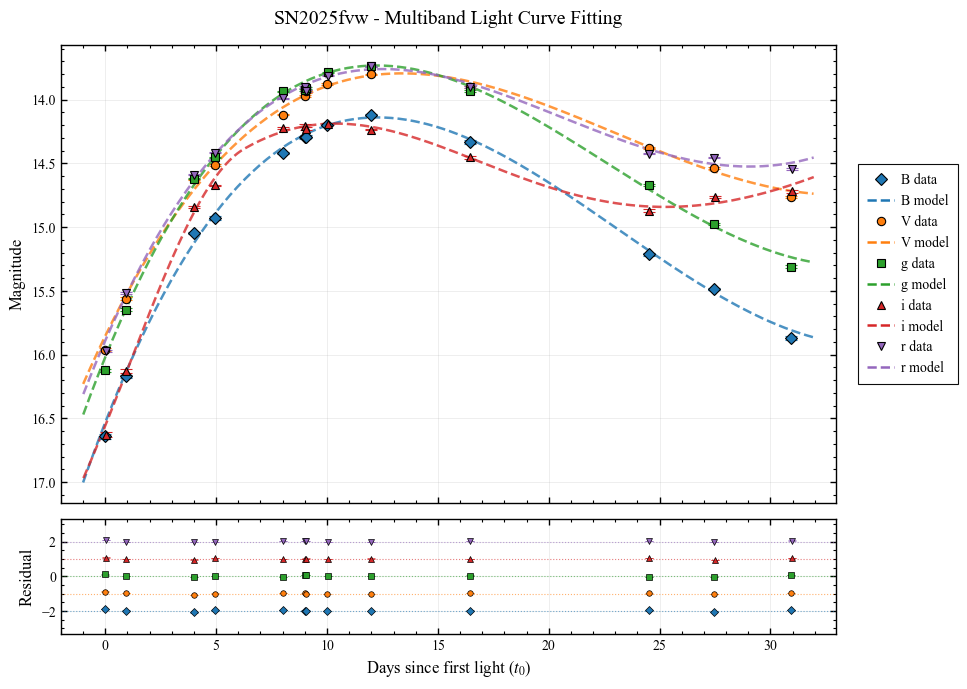

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline
import matplotlib.patches as mpatches

# 设置科学论文风格的matplotlib参数
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'Times', 'DejaVu Serif'],
    'mathtext.fontset': 'stix',  # 数学公式使用STIX字体
    'font.size': 11,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 14,
    'axes.linewidth': 1.0,
    'axes.spines.top': True,     # 显示上边框
    'axes.spines.right': True,   # 显示右边框
    'axes.grid': True,
    'grid.alpha': 0.3,
    'grid.linewidth': 0.5,
    'lines.linewidth': 1.5,
    'lines.markersize': 5,
    'legend.frameon': True,
    'legend.fancybox': False,
    'legend.shadow': False,
    'legend.framealpha': 0.9,
    'legend.edgecolor': 'black',
    'legend.facecolor': 'white',
    'axes.edgecolor': 'black',
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.size': 4,
    'ytick.major.size': 4,
    'xtick.minor.size': 2,
    'ytick.minor.size': 2,
    'xtick.top': True,           # 顶部显示刻度
    'ytick.right': True,         # 右侧显示刻度
    'axes.axisbelow': True
})

def read_supernova_data(filename):
    """
    读取超新星数据文件
    文件包含列：MJD, magnitude, magerr, filter
    """
    try:
        # 尝试读取CSV文件
        data = pd.read_csv(filename)
    except:
        # 如果是Excel文件
        data = pd.read_excel(filename)
    
    return data

def polynomial_fit(x, a, b, c, d, e):
    """多项式拟合函数"""
    return a + b*x + c*x**2 + d*x**3 + e*x**4

def supernova_model(x, peak_mag, baseline_mag, t_peak, rise_time, decay_time):
    """
    超新星光变曲线物理模型 - 不对称高斯模型
    peak_mag: 峰值星等（最亮时）
    baseline_mag: 基线星等（背景）
    t_peak: 峰值时间
    rise_time: 上升时间尺度
    decay_time: 衰减时间尺度
    """
    result = np.where(
        x <= t_peak,
        # 上升阶段：快速上升
        baseline_mag - (baseline_mag - peak_mag) * np.exp(-0.5 * ((x - t_peak) / rise_time)**2),
        # 下降阶段：缓慢衰减
        baseline_mag - (baseline_mag - peak_mag) * np.exp(-0.5 * ((x - t_peak) / decay_time)**2)
    )
    return result

def double_exponential_model(x, A, B, t0, tau_rise, tau_decay):
    """
    双指数模型 - 更符合超新星Ia型光变曲线
    A: 振幅
    B: 基线
    t0: 爆发时间
    tau_rise: 上升时间常数
    tau_decay: 衰减时间常数
    """
    return B + A * (1 - np.exp(-(x - t0) / tau_rise)) * np.exp(-(x - t0) / tau_decay)

def gaussian_like_fit(x, a, b, c, d, e):
    """类高斯拟合函数，适合超新星光变曲线"""
    return a + b * np.exp(-0.5 * ((x - c) / d)**2) + e * x

def improved_supernova_fit(x, mag_peak, mag_base, t_peak, sigma_rise, sigma_decay, linear_term):
    """
    改进的超新星拟合模型，包含线性项
    """
    gaussian_part = np.where(
        x <= t_peak,
        mag_base - (mag_base - mag_peak) * np.exp(-0.5 * ((x - t_peak) / sigma_rise)**2),
        mag_base - (mag_base - mag_peak) * np.exp(-0.5 * ((x - t_peak) / sigma_decay)**2)
    )
    return gaussian_part + linear_term * (x - t_peak)

def plot_light_curve(data, title="SN2025fvw - Multiband Light Curve Fitting"):
    """
    绘制多波段光变曲线 - 改进的拟合方法
    """
    
    # 定义科学论文风格的波段颜色（色盲友好）
    filter_colors = {
        'B': '#1f77b4',    # 蓝色
        'V': '#ff7f0e',    # 橙色
        'g': '#2ca02c',    # 绿色
        'i': '#d62728',    # 红色
        'r': '#9467bd'     # 紫色
    }
    
    # 定义清晰的符号
    filter_symbols = {
        'B': 'D',   # 钻石
        'V': 'o',   # 圆圈
        'g': 's',   # 方形
        'i': '^',   # 上三角
        'r': 'v'    # 下三角
    }
    
    # 计算相对于第一次观测的天数
    first_mjd = data['MJD'].min()
    data['days_since_first'] = data['MJD'] - first_mjd
    
    # 创建图形，使用论文标准比例
    fig = plt.figure(figsize=(10, 8))  # 调整图形大小以容纳外部图例
    
    # 创建子图，主图占更大比例
    gs = fig.add_gridspec(3, 1, height_ratios=[4, 1, 0.1], hspace=0.08)
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1], sharex=ax1)
    
    # 存储拟合结果用于残差计算
    fit_results = {}
    legend_elements = []
    
    # 为每个波段绘制数据和拟合
    unique_filters = sorted(data['filter'].unique())  # 排序确保一致性
    
    print("开始绘制各波段数据...")
    for filt in unique_filters:
        if filt not in filter_colors:
            continue
            
        # 筛选当前波段数据
        mask = data['filter'] == filt
        x_data = data[mask]['days_since_first'].values
        y_data = data[mask]['magnitude'].values
        y_err = data[mask]['magerr'].values  # 确保使用误差数据
        
        if len(x_data) < 5:  # 数据点太少，跳过拟合
            continue
        
        color = filter_colors[filt]
        symbol = filter_symbols[filt]
        
        print(f"波段 {filt}: {len(x_data)} 个数据点")
        print(f"  - 星等范围: {y_data.min():.3f} - {y_data.max():.3f}")
        print(f"  - 误差范围: {y_err.min():.3f} - {y_err.max():.3f}")
        print(f"  - 平均误差: {y_err.mean():.3f}")
        
        # 绘制数据点（带误差棒） - 增强误差棒显示
        eb = ax1.errorbar(x_data, y_data, yerr=y_err, 
                         fmt=symbol, 
                         color=color, 
                         markersize=6,           # 增大标记大小
                         capsize=4,              # 增大误差棒帽子
                         capthick=1.5,           # 增粗误差棒帽子
                         elinewidth=1.5,         # 增粗误差棒线条
                         markeredgecolor='black', 
                         markeredgewidth=0.8,    # 增粗标记边框
                         markerfacecolor=color,
                         ecolor=color,           # 确保误差棒颜色与标记一致
                         alpha=1.0,              # 完全不透明
                         zorder=20)              # 设置很高的zorder确保在最前景
        
        # 进行改进的拟合
        try:
            # 估计初始参数
            mag_peak_est = y_data.min()  # 最亮（最小星等）
            mag_base_est = y_data.max()  # 基线（最暗星等）
            t_peak_est = x_data[np.argmin(y_data)]  # 峰值时间
            time_span = x_data.max() - x_data.min()
            
            # 尝试多种拟合模型，选择最佳的
            best_fit = None
            best_residual = np.inf
            best_model_name = ""
            
            # 模型1：改进的超新星模型
            try:
                p0_improved = [mag_peak_est, mag_base_est, t_peak_est, time_span/6, time_span/3, 0.01]
                bounds_improved = ([mag_peak_est-2, mag_base_est-1, x_data.min(), 0.1, 0.5, -0.1],
                                 [mag_peak_est+1, mag_base_est+2, x_data.max(), time_span/2, time_span, 0.1])
                
                popt_improved, pcov_improved = curve_fit(
                    improved_supernova_fit, x_data, y_data, 
                    p0=p0_improved, 
                    sigma=y_err, 
                    absolute_sigma=True,
                    bounds=bounds_improved,
                    maxfev=5000
                )
                
                y_model_improved = improved_supernova_fit(x_data, *popt_improved)
                residual_improved = np.sum((y_data - y_model_improved)**2 / y_err**2)
                
                if residual_improved < best_residual:
                    best_residual = residual_improved
                    best_fit = (improved_supernova_fit, popt_improved)
                    best_model_name = "Improved SN Model"
                    
            except Exception as e:
                print(f"  改进模型拟合失败: {e}")
            
            # 模型2：超新星物理模型
            try:
                p0_sn = [mag_peak_est, mag_base_est, t_peak_est, time_span/8, time_span/4]
                bounds_sn = ([mag_peak_est-2, mag_base_est-1, x_data.min(), 0.1, 0.5],
                           [mag_peak_est+1, mag_base_est+2, x_data.max(), time_span/2, time_span])
                
                popt_sn, pcov_sn = curve_fit(
                    supernova_model, x_data, y_data, 
                    p0=p0_sn, 
                    sigma=y_err, 
                    absolute_sigma=True,
                    bounds=bounds_sn,
                    maxfev=5000
                )
                
                y_model_sn = supernova_model(x_data, *popt_sn)
                residual_sn = np.sum((y_data - y_model_sn)**2 / y_err**2)
                
                if residual_sn < best_residual:
                    best_residual = residual_sn
                    best_fit = (supernova_model, popt_sn)
                    best_model_name = "Physical SN Model"
                    
            except Exception as e:
                print(f"  物理模型拟合失败: {e}")
            
            # 模型3：高斯类模型（备选）
            try:
                p0_gauss = [mag_base_est, mag_base_est-mag_peak_est, t_peak_est, time_span/6, 0.01]
                popt_gauss, pcov_gauss = curve_fit(
                    gaussian_like_fit, x_data, y_data, 
                    p0=p0_gauss, 
                    sigma=y_err, 
                    absolute_sigma=True,
                    maxfev=5000
                )
                
                y_model_gauss = gaussian_like_fit(x_data, *popt_gauss)
                residual_gauss = np.sum((y_data - y_model_gauss)**2 / y_err**2)
                
                if residual_gauss < best_residual:
                    best_residual = residual_gauss
                    best_fit = (gaussian_like_fit, popt_gauss)
                    best_model_name = "Gaussian-like Model"
                    
            except Exception as e:
                print(f"  高斯模型拟合失败: {e}")
            
            # 如果所有模型都失败，使用样条拟合作为备选
            if best_fit is None:
                print(f"  所有参数化模型拟合失败，使用样条拟合")
                x_sorted_idx = np.argsort(x_data)
                x_sorted = x_data[x_sorted_idx]
                y_sorted = y_data[x_sorted_idx]
                
                spline = UnivariateSpline(x_sorted, y_sorted, s=len(x_data)*0.1)
                best_fit = (spline, None)
                best_model_name = "Spline Fit"
            
            print(f"  最佳拟合模型: {best_model_name}, 残差: {best_residual:.3f}")
            
            # 生成拟合曲线
            x_fit = np.linspace(x_data.min()-1, x_data.max()+1, 200)
            if best_fit[1] is not None:  # 参数化模型
                y_fit = best_fit[0](x_fit,*best_fit[1])
                y_model = best_fit[0](x_data,*best_fit[1])
            else:  # 样条拟合
                y_fit = best_fit[0](x_fit)
                y_model = best_fit[0](x_data)
            
            # 绘制拟合曲线 - 降低zorder确保在数据点后面
            line = ax1.plot(x_fit, y_fit, '--', color=color, linewidth=1.8,
                           alpha=0.8, zorder=5)
            
            # 计算残差
            residuals = y_data - y_model
            
            # 存储拟合结果
            fit_results[filt] = {
                'x': x_data,
                'residuals': residuals,
                'errors': y_err,
                'model': best_model_name
            }
            
            # 创建图例元素
            legend_elements.extend([
                plt.Line2D([0], [0], marker=symbol, color=color, 
                          linestyle='None', markersize=6, 
                          markeredgecolor='black', markeredgewidth=0.8,
                          markerfacecolor=color,
                          label=f'{filt} data'),
                plt.Line2D([0], [0], color=color, linestyle='--', 
                          linewidth=1.8, label=f'{filt} model')
            ])
            
        except Exception as e:
            print(f"拟合 {filt} 波段时出错: {e}")
            continue
    
    # 设置主图
    ax1.set_ylabel('Magnitude', fontweight='normal')
    ax1.set_title(title, pad=15, fontweight='normal')
    ax1.grid(True, alpha=0.3, linewidth=0.5, zorder=1)  # 确保网格在后面
    ax1.invert_yaxis()  # 反转y轴，星等小的在上方
    
    # 设置主图的刻度
    ax1.tick_params(axis='both', which='major', labelsize=10, 
                    direction='in', top=True, right=True,
                    length=4, width=1.0)
    ax1.tick_params(axis='both', which='minor', direction='in', 
                    top=True, right=True, length=2, width=0.8)
    
    # 启用次要刻度
    ax1.minorticks_on()
    
    # 移除主图的x轴标签
    plt.setp(ax1.get_xticklabels(), visible=False)
    
    # 设置图例 - 放在图外右侧，避免遮挡曲线
    legend = ax1.legend(handles=legend_elements, 
                       loc='center left',
                       bbox_to_anchor=(1.02, 0.5),  # 放在图外右侧
                       ncol=1,
                       columnspacing=0.8,
                       handletextpad=0.5,
                       borderpad=0.6,
                       framealpha=0.95)
    legend.get_frame().set_linewidth(0.8)
    
    # 绘制残差图
    print("绘制残差图...")
    for i, filt in enumerate(unique_filters):
        if filt not in fit_results:
            continue
            
        result = fit_results[filt]
        color = filter_colors[filt]
        symbol = filter_symbols[filt]
        
        # 计算垂直偏移
        offset = (i - len(unique_filters)/2 + 0.5) * 1.0
        
        # 绘制残差点（带误差棒） 
        ax2.errorbar(result['x'], result['residuals'] + offset, 
                    yerr=result['errors'],
                    fmt=symbol, 
                    color=color, 
                    markersize=4,
                    capsize=3,              # 残差图误差棒
                    capthick=1.2, 
                    elinewidth=1.2,
                    markeredgecolor='black', 
                    markeredgewidth=0.5,
                    markerfacecolor=color,
                    ecolor=color,           # 确保误差棒颜色
                    alpha=1.0,              # 完全不透明
                    zorder=20)
        
        # 绘制零线
        x_range = [data['days_since_first'].min()-2, data['days_since_first'].max()+2]
        ax2.plot(x_range, [offset, offset], 
                color=color, linestyle=':', alpha=0.6, linewidth=0.8, zorder=1)
        
        print(f"  {filt} 波段: {result['model']}, RMS残差: {np.sqrt(np.mean(result['residuals']**2)):.3f}")
    
    # 设置残差图
    ax2.set_xlabel(r'Days since first light ($t_0$)', fontweight='normal')
    ax2.set_ylabel('Residual', fontweight='normal')
    ax2.grid(True, alpha=0.3, linewidth=0.5, zorder=1)
    ax2.tick_params(axis='both', which='major', labelsize=10, 
                    direction='in', top=True, right=True,
                    length=4, width=1.0)
    ax2.tick_params(axis='both', which='minor', direction='in', 
                    top=True, right=True, length=2, width=0.8)
    ax2.minorticks_on()
    
    # 设置残差图的y轴范围
    n_filters = len([f for f in unique_filters if f in fit_results])
    y_range = n_filters * 1.0
    ax2.set_ylim(-y_range/2 - 0.8, y_range/2 + 0.8)
    
    # 设置x轴范围一致
    x_min = data['days_since_first'].min() - 2
    x_max = data['days_since_first'].max() + 2
    ax1.set_xlim(x_min, x_max)
    ax2.set_xlim(x_min, x_max)
    
    # 调整布局以容纳外部图例
    plt.tight_layout()
    
    # 确保所有边框都显示
    for ax in [ax1, ax2]:
        for spine in ax.spines.values():
            spine.set_linewidth(1.0)
            spine.set_color('black')
            spine.set_visible(True)
    
    print("图形绘制完成！")
    return fig

def main():
    """
    主函数 - 使用示例
    """
    # 读取数据文件
    filename = "LC_2025FVW.csv" 
    
    data = read_supernova_data(filename)
    print("数据文件读取成功！")
    print(f"数据形状: {data.shape}")
    print(f"列名: {data.columns.tolist()}")
    print(f"波段: {data['filter'].unique()}")
    print(f"星等范围: {data['magnitude'].min():.2f} - {data['magnitude'].max():.2f}")
    print(f"误差范围: {data['magerr'].min():.3f} - {data['magerr'].max():.3f}")
        
    # 绘制光变曲线
    fig = plot_light_curve(data)
        
    # 保存图片 - 科学论文标准
    plt.savefig('improved_supernova_light_curve.pdf', 
                dpi=300, bbox_inches='tight', 
                facecolor='white', edgecolor='none',
                format='pdf')  
    plt.savefig('improved_supernova_light_curve.png', 
                dpi=300, bbox_inches='tight',
                facecolor='white', edgecolor='none')
    plt.show()

if __name__ == "__main__":
    main()

The fitting results for the r filter and i filter exhibit an anomalous increase in the later stages. Examination of the raw data confirms that the i filter's measurements do show an increase towards the end, which may be attributed either to observational errors or a secondary outburst in this band during the late phase. In contrast, the r band data does not show an increase. The suboptimal fitting performance in this part is due to limitations in the model we employed.

Each band's light curve shows an initial rise in brightness (decreasing magnitude), reaching a peak, and then a decline. The peak magnitude and the rate of decline vary between the different bands. The B band (blue) has the steepest decline after its peak. The r band (purple) appears to have the shallowest decline.